# Automotive industry sites

In [1]:
import pandas as pd
import numpy as np
from shapely.ops import transform

#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.offsetbox import AnchoredText

from pynsee import *

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
init_conn(sirene_key='f7345356-8301-4567-b453-568301456723')

In [4]:
# get activity list
naf5 = get_activity_list('NAF5')

# search data in SIRENE database
data = search_sirene(variable="activitePrincipaleEtablissement",
                     pattern='29.10Z', kind='siret', number=2000)

2/2 - Getting data: 100%|██████████| 342/342 [00:00<00:00, 342.96it/s]
This function may return personal data, please check and comply with the legal framework relating to personal data protection !


In [5]:
# keep only businesses with more then 100 employees
df = data.loc[data['effectifsMinEtablissement'] > 100]
df = df.reset_index(drop=True)
# find latitude and longitude of all businesses
gdf = df.get_location().sort_values(by=['effectifsMinEtablissement'], ascending=False)

Getting location: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


In [6]:
# get map - departement limits
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement', update=True)
mapdep = mapdep.transform_overseas()
mapdep.head()

,geometry,id,nom_m,nom,insee_dep,insee_reg
0,"MULTIPOLYGON (((533820.757 5815685.538, 533972...",DEPARTEM_FXX_00000000001,AIN,Ain,01,84
1,"MULTIPOLYGON (((347405.807 6395467.47, 347374....",DEPARTEM_FXX_00000000002,AISNE,Aisne,02,32
2,"MULTIPOLYGON (((1046859.484 5315956.073, 10468...",DEPARTEM_FXX_00000000003,HAUTE-CORSE,Haute-Corse,2B,94
3,"MULTIPOLYGON (((955740.729 5142374.305, 955755...",DEPARTEM_FXX_00000000004,CORSE-DU-SUD,Corse-du-Sud,2A,94
4,"MULTIPOLYGON (((282378.517 5864026.958, 282436...",DEPARTEM_FXX_00000000005,ALLIER,Allier,03,84


In [26]:
def get_carmaker_pattern(x):
    match_list = ['RENAULT SAS', 'ALPINE', 'BATILLY', 'MAUBEUGE CONSTRUCTION',
              'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS']
    
    values = ['RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS', 'RENAULT SAS',
              'TOYOTA', 'STELLANTIS AUTO SAS', 'RENAULT TRUCKS']

    pattern = [values[i] for i, p in enumerate(match_list) if p in x]
    
    if len(pattern)  == 0:
        return "OTHER"
    else:
        return pattern[0]

In [27]:
gdf['label'] = gdf['denominationUniteLegale'].apply(lambda x: get_carmaker_pattern(x))

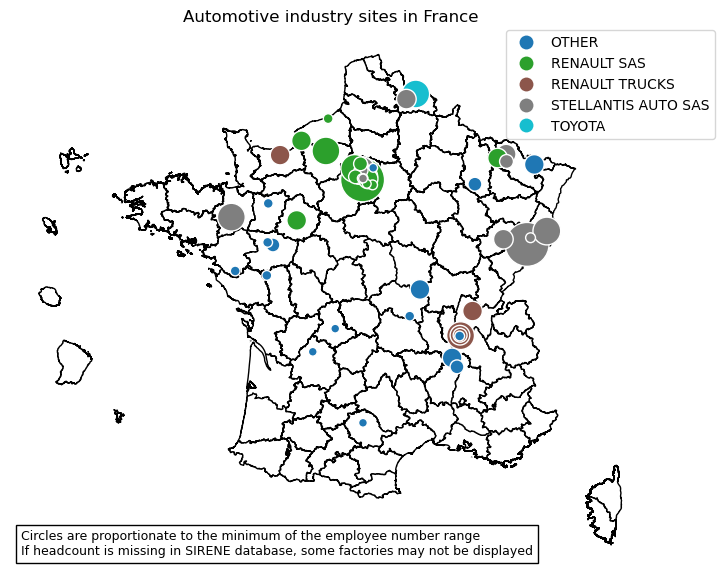

In [28]:
# change projection
gdf = gdf.to_crs('EPSG:3857')
# annotation
txt = 'Circles are proportionate to the minimum of the employee number range'
txt += '\nIf headcount is missing in SIRENE database, some factories may not be displayed'

#plot
ax = mapdep.plot(color='white', edgecolor='black', figsize = (15,7))
plt.title('Automotive industry sites in France')
gdf.plot(ax=ax,
         column = 'label',
         edgecolor='white',
         markersize=gdf.effectifsMinEtablissement/5,
         legend=True,
         legend_kwds={'bbox_to_anchor': (1.1,1),
                       'loc':1, 'borderaxespad': 0})

at = AnchoredText(txt, prop=dict(size=9), frameon=True, loc='lower left')
ax.add_artist(at)
ax.set_axis_off()
plt.show()